In [1]:
import pandas as pd
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt

In [2]:
file_match_dict = {}
f_dict = dict(zip(sorted(glob.glob('./*.collapsed.*')), sorted(glob.glob('./seq_dir/*.fasta'))))
for key in f_dict:
    file_key = '_'.join(key.split('./')[1].split('_')[:2])
    file_match_dict[file_key] = [key,f_dict[key] ]
file_match_dict

{'background_dom': ['./background_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out',
  './seq_dir/background_sequences.fasta'],
 'downstream_activator': ['./downstream_activator_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out',
  './seq_dir/downstream_activator_sequences.fasta'],
 'downstream_inhibitor': ['./downstream_inhibitor_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out',
  './seq_dir/downstream_inhibitor_sequences.fasta'],
 'upstream_activator': ['./upstream_activator_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out',
  './seq_dir/upstream_activator_sequences.fasta'],
 'upstream_inhibitor': ['./upstream_inhibitor_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out',
  './seq_dir/upstream_inhibitor_sequences.fasta']}

In [3]:
background_df = pd.read_csv('./background_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out', 
                            sep='\t',
                           header=None)

In [4]:
background_df

,0,1,2,3,4,5,6,7,8,9
0,RRM_1,70,A1CF|BC054873.1,122,3.700000e-17,1,64,58,121,0.900000
1,Thiolase_C,123,ACAA2|BC001918.1,397,1.600000e-51,2,122,274,394,0.975610
2,Thiolase_N,260,ACAA2|BC001918.1,397,1.600000e-97,1,260,7,266,0.996154
3,Spectrin,105,ACTN4|BC005033.1,911,1.300000e-14,3,105,530,639,0.971429
4,EFhand_Ca_insen,69,ACTN4|BC005033.1,911,1.400000e-27,1,69,841,907,0.985507
...,...,...,...,...,...,...,...,...,...,...
1883,zf-CCCH,27,"ZRSR2|BC113454.1,",482,2.900000e-08,2,26,168,192,0.888889
1884,RRM_1,70,"ZRSR2|BC113454.1,",482,5.300000e-05,13,69,241,297,0.800000
1885,LIM,58,"ZYX|BC008743.2,",572,1.100000e-12,1,57,444,499,0.965517
1886,LIM,58,"ZYX|BC008743.2,",572,3.900000e-14,1,56,384,439,0.948276


In [5]:
from Bio import SeqIO  # Biopython

def get_numseqs_and_headers(fa_path):
    headers = []
    num_seqs = 0
    for record in SeqIO.parse(fa_path, "fasta"):
        num_seqs += 1
        headers.append(record.id)  # or record.description if you want the full header
    return num_seqs, headers
    
def get_counts(df_path, fa):
    df  = pd.read_csv(df_path, sep='\t', header=None)
    all_proteins = df[2].unique()
    N, headers = get_numseqs_and_headers(fa) # accounts for the fact that some RBPs have no domains and are not in the hmm output
    category_bkg = background_df[~background_df[2].isin(headers)] # only looking at domain information for proteins only in background
    N_total_bkg, headers_total_bkg = get_numseqs_and_headers('./seq_dir/background_sequences.fasta')
    N_bkg = len(set(headers_total_bkg) - set(headers)) # getting the number of proteins only in background
    
    # proteins per domain (unique proteins, not hits)
    has_counts = df.groupby(0)[2].nunique().rename('has_domain')
    has_counts_bkg = category_bkg.groupby(0)[2].nunique().rename('has_domain')

    # build contingency-ready table
    domain_counts = (
        has_counts
        .to_frame()
        .assign(no_domain=lambda x: N - x['has_domain'])
        .reset_index()
        .rename(columns={0: 'domain'})
    )
    domain_counts_bkg = (
        has_counts_bkg
        .to_frame()
        .assign(no_domain=lambda y:N_bkg - y['has_domain'])
        .reset_index()
        .rename(columns={0: 'domain'})
    )
    return domain_counts.set_index('domain'), domain_counts_bkg.set_index('domain')

In [6]:
import numpy as np
from scipy.stats import fisher_exact, chisquare
from statsmodels.stats.multitest import multipletests

# dct is your dictionary like:
# dct = {'background_dom': df_bg, 'downstream_activator': df1, 'downstream_inhibitor': df2, ...}
   
# Fisher's exact (enrichment in category -> alternative='greater')
def _fisher(row):
    table = [[int(row['has_domain_cat']), int(row['no_domain_cat'])],
             [int(row['has_domain_bkg']), int(row['no_domain_bkg'])]]
    try:
        OR, p = fisher_exact(table, alternative='greater')
    except Exception:
        OR, p = (np.nan, 1.0)
    return pd.Series({'odds_ratio': OR, 'pvalue': p})



In [7]:
all_results = pd.DataFrame()
for f in file_match_dict:
    if f !='background_dom':
        print(f"Files used, domain:{file_match_dict[f][0]} fasta{ file_match_dict[f][1]}")
        d1, d2 = get_counts(file_match_dict[f][0], file_match_dict[f][1])
        merged = d1.merge(d2, right_index=True, left_index=True, suffixes=['_cat', '_bkg'])
        stats = merged.apply(_fisher, axis=1)
        out = merged.join(stats)
        out['category'] = f
        all_results = pd.concat([all_results, out])

Files used, domain:./downstream_activator_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out fasta./seq_dir/downstream_activator_sequences.fasta
Files used, domain:./downstream_inhibitor_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out fasta./seq_dir/downstream_inhibitor_sequences.fasta
Files used, domain:./upstream_activator_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out fasta./seq_dir/upstream_activator_sequences.fasta
Files used, domain:./upstream_inhibitor_dom_hmmscan_out.txt.collapsed.Evalue0.1.0.01.out fasta./seq_dir/upstream_inhibitor_sequences.fasta


In [8]:
all_results['-log10_pval'] = -np.log10(all_results['pvalue'])


In [9]:
all_results[all_results['pvalue']<0.05]

,has_domain_cat,no_domain_cat,has_domain_bkg,no_domain_bkg,odds_ratio,pvalue,category,-log10_pval
domain,,,,,,,,
LSM,5,71,11,782,5.006402,0.009104,downstream_activator,2.040748
NOPS,2,74,2,791,10.689189,0.040344,downstream_activator,1.394223
OCRE,2,74,1,792,21.405405,0.021380,downstream_activator,1.669986
RRM_1,20,56,128,665,1.855469,0.021858,downstream_activator,1.660382
Staufen_C,3,73,1,792,32.547945,0.002417,downstream_activator,2.616755
zf-CCCH_2,3,73,2,791,16.253425,0.005661,downstream_activator,2.247073
zf-CCCH_4,2,74,2,791,10.689189,0.040344,downstream_activator,1.394223
zf-RanBP,2,74,2,791,10.689189,0.040344,downstream_activator,1.394223
zf-met,2,74,1,792,21.405405,0.021380,downstream_activator,1.669986


In [10]:
sig_domains = all_results[all_results['pvalue']<0.05].index.tolist()

In [11]:
rbd_list = pd.read_excel('./Gerstberger_RBD_list_reformatted.xls')['Pfam RNA binding domains'].tolist()

/scratch/pjaganna1/job_7203889/ipykernel_3036843/323554436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['P-value<0.05'] = to_plot['pvalue']<0.05
/scratch/pjaganna1/job_7203889/ipykernel_3036843/323554436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['log(Odds Ratio)'] = np.log10(to_plot['odds_ratio'])
/scratch/pjaganna1/job_7203889/ipykernel_3036843/323554436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

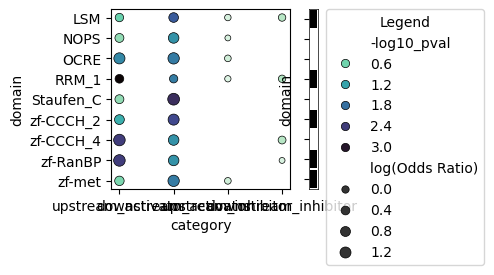

In [16]:
to_plot = all_results[all_results.index.isin(sig_domains)]
to_plot['P-value<0.05'] = to_plot['pvalue']<0.05
to_plot['log(Odds Ratio)'] = np.log10(to_plot['odds_ratio'])
to_plot['is_RBD'] = to_plot.index.isin(rbd_list)
# --- Define x-axis order explicitly ---
x_order = ["upstream_activator", "downstream_activator", 
           "upstream_inhibitor", "downstream_inhibitor"]

# Force x-axis categorical order
to_plot['category'] = pd.Categorical(to_plot['category'], categories=x_order, ordered=True)

#y_order = set(to_plot.sort_values(["is_RBD", 'domain'], ascending=[False, True]).domain.tolist())
#to_plot['domain'] = pd.Categorical(to_plot['domain'], categories=y_order, ordered=True)

fig, (ax_scatter, ax_strip) = plt.subplots(
        ncols=2, figsize=(4/1.5, 3.5/1.5),
        gridspec_kw={'width_ratios': [10, 0.5]}, sharey=False
    )
#plt.figure(figsize=(3, 6))
sns.scatterplot(data=to_plot,
            y=to_plot.index,
            x='category',
            hue='-log10_pval',
            size='log(Odds Ratio)',
            palette='mako_r',
            linewidth=0.5,
            edgecolor='black',
               ax=ax_scatter)
#plt.xticks(rotation=45)
# Move legend outside
ax_scatter.legend(
    bbox_to_anchor=(1.2, 1),   # position: 5% to the right of the plot
    loc='upper left',           # anchor location relative to bbox
    borderaxespad=0.,           # space between plot and legend
    title="Legend"              # optional custom title
)

sns.heatmap(
        data=to_plot[['is_RBD']].reset_index().drop_duplicates(['domain', 'is_RBD']).set_index('domain'),
        #x='is_RBD',
        #y='domain',
        cmap='binary',
        cbar=False,
        ax=ax_strip,
        linewidth=0.2
    )
for spine in ax_strip.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  # Adjust linewidth as needed
    spine.set_edgecolor("black")
ax_strip.set_yticklabels([])
plt.savefig('./figures/domain_enrichment_bkg_corrected.png')
plt.savefig('./figures/domain_enrichment_bkg_corrected.svg')
plt.savefig('./figures/domain_enrichment_bkg_corrected.jpg')